In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyspark
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from astropy.table import Table 
spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
    
    

In [3]:
spark

In [4]:
spark.catalog.listTables()

[Table(name='_gatspy_ztf2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='asassn_variability_catalog', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway3', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_labeled_training_dataset', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_set', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='f

In [43]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
ztf_lc = axs_catalog.load("ztf_1am_lc")

In [44]:
%%time
# Select only one filter , eg . g ...
from pyspark.sql.functions import array_contains

fid = 1
ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>100) & (array_contains(ztf_lc['filterid'], fid))).\
    limit(10000).toPandas()
    


CPU times: user 188 ms, sys: 39.1 ms, total: 227 ms
Wall time: 8.02 s


In [46]:
from astropy.table import Table
ztf__table = Table.from_pandas(ztf_lc_fid)

In [47]:
pwd

'/data/epyc/users/suberlak'

In [48]:
ztf__table.write('ztf_1am_lc_ngoodobs_gt_100_filterid_1_limit10000.txt',
                format='ascii')

In [20]:
def calc_lsst_error(m):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for g-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    sigma_sys = 0.005
    gamma = 0.038
    m5 = 25
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

Text(0.5, 1.0, 'ngoodobs > 100')

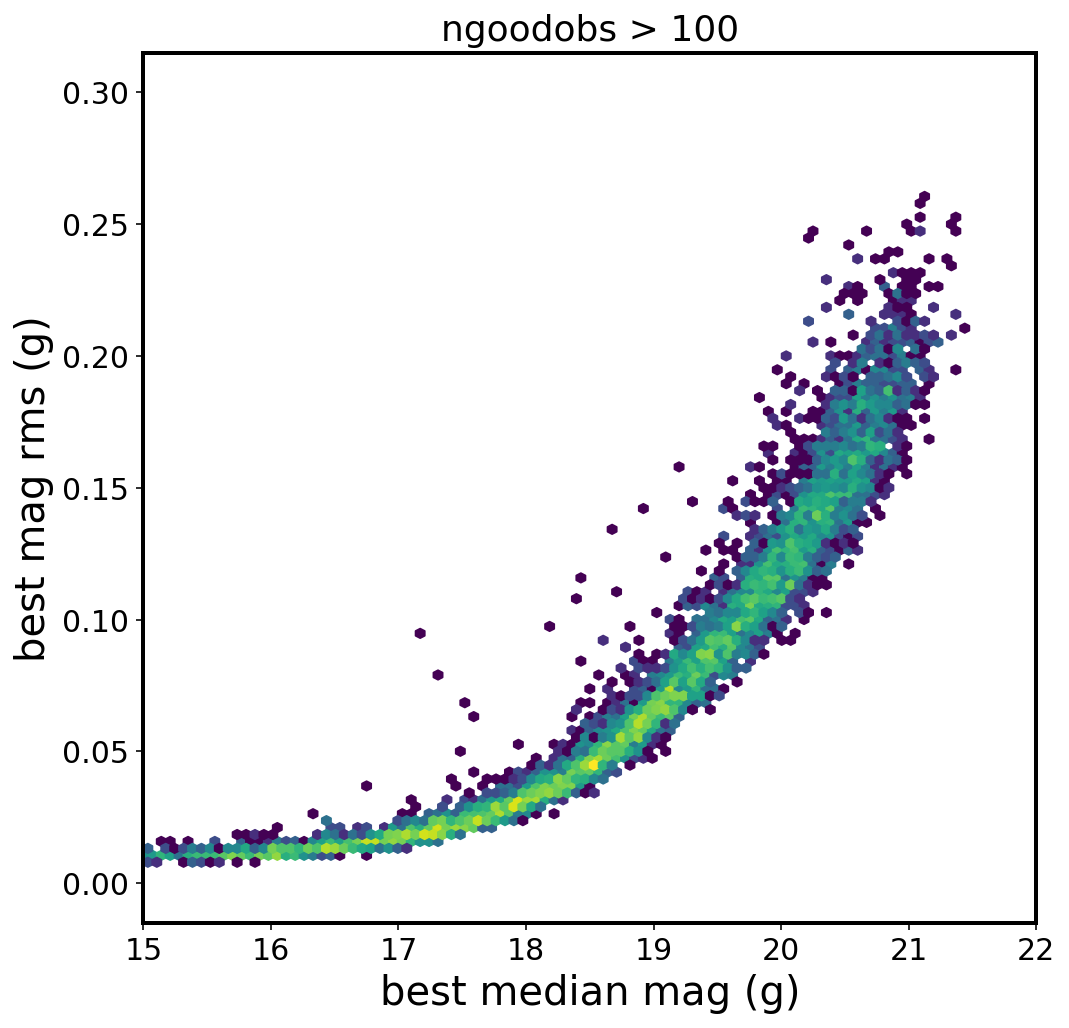

In [42]:
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
# magnitude scatter can serve as  a proxy for photometric noise ... 
fig,ax = plt.subplots(1,1, figsize=(8,8))
x,y = ztf_lc_fid['bestmedianmag'],ztf_lc_fid['bestmagrms']
ax.hexbin(x,y , extent=(15,22,0,0.3), mincnt=2, bins='log')
#ax.plot(x, calc_lsst_error(x))
ax.set_xlim(15,22)
# I can use that because I can't find the photometric noise model... 
ax.set_xlabel('best median mag (g)')
ax.set_ylabel('best mag rms (g)')
ax.set_title('ngoodobs > 100')

In [38]:
ax.hexbin?